In [32]:
import sklearn
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
import seaborn as sn
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from rdkit.Avalon import pyAvalonTools


In [2]:
dataset = pd.read_excel('C:/Users/Gashaw/Documents/DataAndSoftware_S1-S4/Orbital_Energies_input_data.xlsx')
dataset.head()

,SMILES,Energygap
0,Nc1ccc(cc1)C(F)(F)F,177.756984
1,CNC1CCCCC1,215.558754
2,C/C=C/C(C)C,220.858695
3,OC(=O)c1ccccc1c1ccccc1,168.397060
4,OC(=O)/C=C\c1c[nH]c2ccccc12,144.475790


In [3]:
  X, y  = dataset['SMILES'], dataset['Energygap']
    

In [4]:
y

0       177.756984
1       215.558754
2       220.858695
3       168.397060
4       144.475790
           ...    
2899    217.786411
2900    156.612441
2901    220.300840
2902    270.098071
2903    177.377969
Name: Energygap, Length: 2904, dtype: float64

In [5]:
X

0                       Nc1ccc(cc1)C(F)(F)F
1                                CNC1CCCCC1
2                               C/C=C/C(C)C
3                    OC(=O)c1ccccc1c1ccccc1
4               OC(=O)/C=C\c1c[nH]c2ccccc12
                       ...                 
2899                              O=c1occo1
2900                  OC(=O)Cc1cccc2ccccc12
2901                  CC(=O)CC(=O)OC(C)(C)C
2902    FC(F)(F)S(=O)(=O)OS(=O)(=O)C(F)(F)F
2903                        COc1ccc(cc1)C#N
Name: SMILES, Length: 2904, dtype: object

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [9]:
# Calculating Morgan, rdkit and Avalon fingerprints for training sets
train_morgan_fps = []
train_rd_fps = []
train_avalon_fps=[]
train_info=[]


for i in X_train:
    mol = Chem.MolFromSmiles(i) 
    info = {}
    temp = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048,bitInfo=info)
    train_morgan_fps.append(temp)
    train_info.append(info)
    train_rd_fps.append(Chem.RDKFingerprint(mol))
    train_avalon_fps.append(pyAvalonTools.GetAvalonFP(mol))
   


In [10]:
# Calculating morgan, rdkit and avalon fingerprints for test sets
test_morgan_fps = []
test_rd_fps = []
test_avalon_fps=[]
test_info=[]
    
for j in X_test:
    mol = Chem.MolFromSmiles(j) 
    info = {}
    temp = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048,bitInfo=info)
    test_morgan_fps.append(temp)
    test_info.append(info)
    test_rd_fps.append(Chem.RDKFingerprint(mol))
    test_avalon_fps.append(pyAvalonTools.GetAvalonFP(mol))
      

In [11]:
rf = RandomForestRegressor(random_state=42)

In [12]:
# Data preprocessing using pipeline 
pipe = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('preprocessor', SimpleImputer()),
        ('model', rf)])

In [13]:
# Model Training and prediction
pipe.fit(train_avalon_fps,y_train) # training using 70% of the data
rf_prediction_Av = pipe.predict(test_avalon_fps) # predicting yield for 30% of the data

In [14]:
#Model accuracy using root mean square error 
rmse_av = np.sqrt(mean_squared_error(y_test, rf_prediction_Av)) 
print('rmse_av:', rmse_av)

rmse_av: 11.451050313281739


In [15]:
# R^2 (coefficient of determination) regression score function: 
R2_av =r2_score(y_test, rf_prediction_Av)
print('R^2:', R2_av)

R^2: 0.8688178691274019


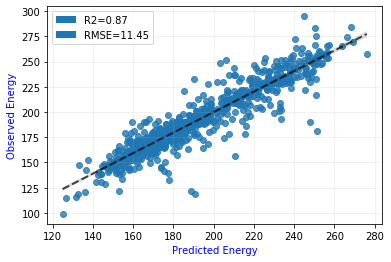

In [16]:
import matplotlib.patches as mpatches
sn.regplot(x=rf_prediction_Av, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy', color='blue')
plt.ylabel('Observed Energy', color ='blue')
plt.grid(alpha=0.2)
R2_av = mpatches.Patch(label="R2={:04.2f}".format(R2_av))
rmse_av = mpatches.Patch(label="RMSE={:04.2f}".format(rmse_av))
plt.legend(handles=[R2_av, rmse_av])

In [33]:
# Model Training and prediction
pipe.fit(train_morgan_fps,y_train) # training using 70% of the data
rf_prediction_mr = pipe.predict(test_morgan_fps) # predicting yield for 30% of the data

In [48]:
#Model accuracy using root mean square error 
rmse_mr = np.sqrt(mean_squared_error(y_test, rf_prediction_mr)) 
print('rmse:', rmse_mr)

rmse: 11.462352679656446


In [50]:
# R^2 (coefficient of determination) regression score function: 
R2_mr =r2_score(y_test, rf_prediction_mr)
print('R^2:', R2_mr)

R^2: 0.8685587836858231


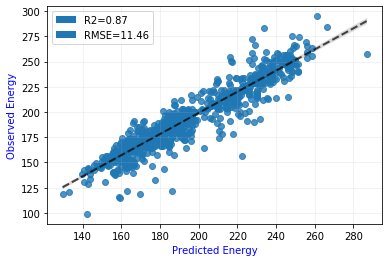

In [51]:
import matplotlib.patches as mpatches
sn.regplot(x=rf_prediction_mr, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy', color='blue')
plt.ylabel('Observed Energy', color ='blue')
plt.grid(alpha=0.2)
R2_mr = mpatches.Patch(label="R2={:04.2f}".format(R2_mr))
rmse_mr = mpatches.Patch(label="RMSE={:04.2f}".format(rmse_mr))
plt.legend(handles=[R2_mr, rmse_mr])

In [52]:
# Model Training and prediction
pipe.fit(train_rd_fps, y_train) # training using 70% of the data
rf_prediction_rd = pipe.predict(test_rd_fps) # predicting yield for 30% of the data

In [53]:
#Model accuracy using root mean square error 
rmse_rd = np.sqrt(mean_squared_error(y_test, rf_prediction_rd)) 
print('rmse_rd:', rmse_rd)

rmse_rd: 11.143978709820068


In [54]:
# R^2 (coefficient of determination) regression score function: 
R2_rd =r2_score(y_test, rf_prediction_rd)
print('R^2:', R2_rd)

R^2: 0.8757591016939004


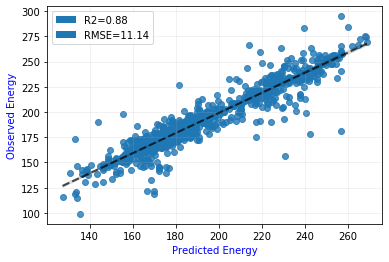

In [55]:
import matplotlib.patches as mpatches
sn.regplot(x=rf_prediction_rd, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy', color='blue')
plt.ylabel('Observed Energy', color ='blue')
plt.grid(alpha=0.2)
R2_rd = mpatches.Patch(label="R2={:04.2f}".format(R2_rd))
rmse_rd = mpatches.Patch(label="RMSE={:04.2f}".format(rmse_rd))
plt.legend(handles=[R2_rd, rmse_rd])

In [56]:
# XGBoost the most widely used ML model in kaggle competition
xgb = XGBRegressor(random_state=42)

In [57]:
# Data preprocessing using pipeline 
pipe2 = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('preprocessor', SimpleImputer()),
        ('model', xgb)])

In [58]:
pipe2.fit(train_morgan_fps,y_train)
xgb_prediction_mr = pipe2.predict(test_morgan_fps)


In [59]:
# Model accuracy using root mean square error 
rmse2_mr = np.sqrt(mean_squared_error(y_test, xgb_prediction_mr))  
print('rmse2:', rmse2_mr)


rmse2: 12.656887355705456


In [60]:
# R^2 (coefficient of determination) regression score function: 
R_2_mr =r2_score(y_test, xgb_prediction_mr)
print('R^2:', R_2_mr)

R^2: 0.8397353035340853


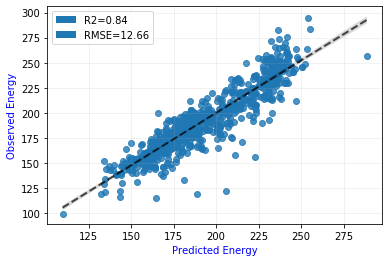

In [61]:
import matplotlib.patches as mpatches
sn.regplot(x=xgb_prediction_mr, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy', color='blue')
plt.ylabel('Observed Energy', color ='blue')
plt.grid(alpha=0.2)
R_2_mr = mpatches.Patch(label="R2={:04.2f}".format(R_2_mr))
rmse2_mr = mpatches.Patch(label="RMSE={:04.2f}".format(rmse2_mr))
plt.legend(handles=[R_2_mr, rmse2_mr])

In [64]:
pipe2.fit(train_rd_fps,y_train)
xgb_prediction_rd = pipe2.predict(test_rd_fps)

In [65]:
# Model accuracy using root mean square error 
rmse2_rd = np.sqrt(mean_squared_error(y_test, xgb_prediction_rd))  
print('rmse2:', rmse2_rd)

rmse2: 11.848189849328461


In [66]:
# R^2 (coefficient of determination) regression score function: 
R_2_rd =r2_score(y_test, xgb_prediction_rd)
print('R^2:', R_2_rd)

R^2: 0.8595608978218069


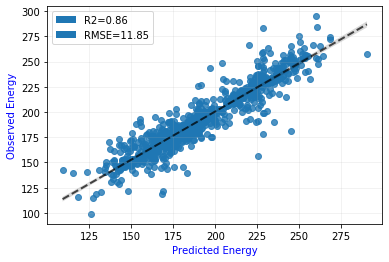

In [67]:
import matplotlib.patches as mpatches
sn.regplot(x=xgb_prediction_rd, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy', color='blue')
plt.ylabel('Observed Energy', color ='blue')
plt.grid(alpha=0.2)
R_2_rd = mpatches.Patch(label="R2={:04.2f}".format(R_2_rd))
rmse2_rd = mpatches.Patch(label="RMSE={:04.2f}".format(rmse2_rd))
plt.legend(handles=[R_2_rd, rmse2_rd])

In [69]:
pipe2.fit(train_avalon_fps,y_train)
xgb_prediction_av = pipe2.predict(test_avalon_fps)

In [70]:
# Model accuracy using root mean square error 
rmse2_av = np.sqrt(mean_squared_error(y_test, xgb_prediction_av))  
print('rmse2:', rmse2_av)

rmse2: 11.273362187078396


In [71]:
# R^2 (coefficient of determination) regression score function: 
R_2_av =r2_score(y_test, xgb_prediction_av)
print('R^2:', R_2_av)

R^2: 0.8728574388377506


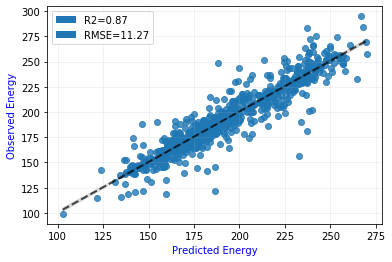

In [72]:
import matplotlib.patches as mpatches
sn.regplot(x=xgb_prediction_av, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy', color='blue')
plt.ylabel('Observed Energy', color ='blue')
plt.grid(alpha=0.2)
R_2_av = mpatches.Patch(label="R2={:04.2f}".format(R_2_av))
rmse2_av = mpatches.Patch(label="RMSE={:04.2f}".format(rmse2_av))
plt.legend(handles=[R_2_av, rmse2_av])